In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, text, inspect


In [4]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [6]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [7]:
# Assign the measurement class to a variable called `Measurement` and
# assign the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create a session
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()

print(f"The most recent date in the dataset is:, {most_recent_date}")

The most recent date in the dataset is: 2017-08-23


(array([-250.,    0.,  250.,  500.,  750., 1000., 1250., 1500., 1750.,
        2000., 2250.]),
 [Text(-250.0, 0, '2017-07-02'),
  Text(0.0, 0, '2016-08-24'),
  Text(250.0, 0, '2016-10-06'),
  Text(500.0, 0, '2016-11-17'),
  Text(750.0, 0, '2017-01-01'),
  Text(1000.0, 0, '2017-02-14'),
  Text(1250.0, 0, '2017-04-01'),
  Text(1500.0, 0, '2017-05-15'),
  Text(1750.0, 0, '2017-06-29'),
  Text(2000.0, 0, '2017-08-19'),
  Text(2250.0, 0, '')])

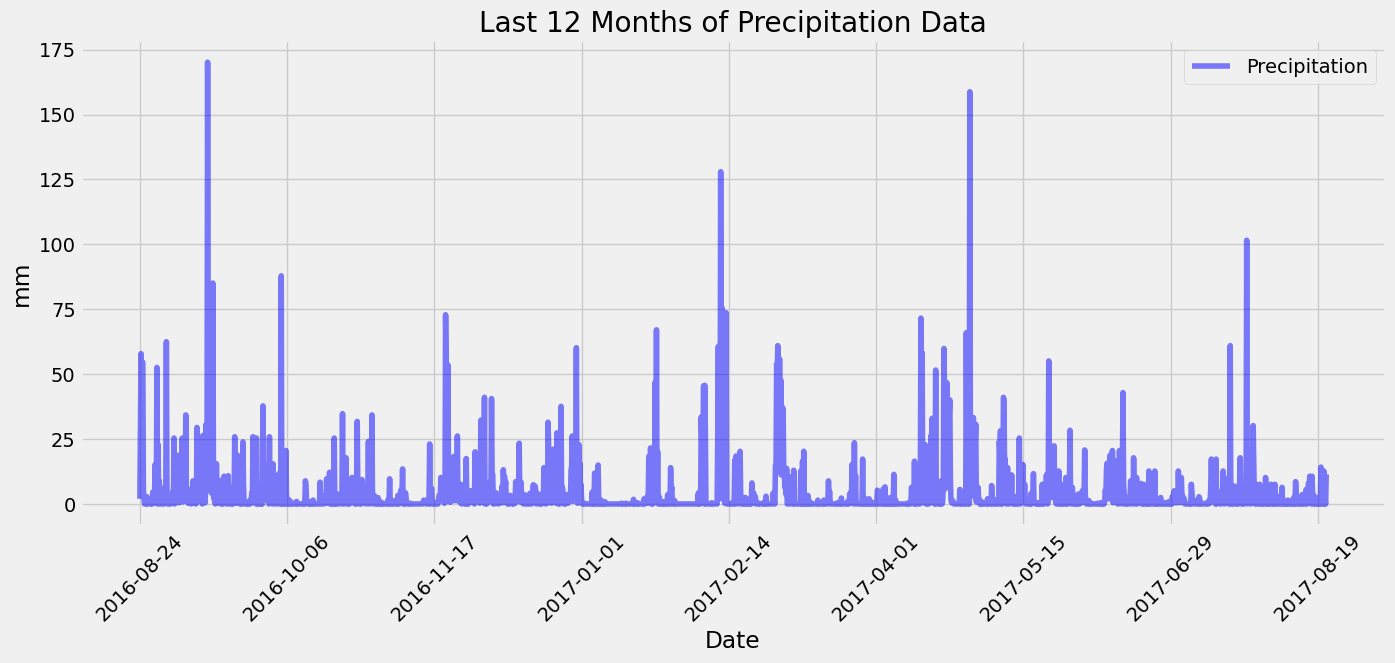

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
    
# Calculate the date one year from the last date in data set.
last_12_months = dt.datetime.strptime(most_recent_date, "%Y-%m-%d") - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_scores = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >=last_12_months).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_scores_df = pd.DataFrame(precipitation_scores, columns=["Date", "Precipitation"])
precipitation_scores_df.set_index('Date', inplace=True)
df = precipitation_scores_df.dropna()
df = df.sort_values(by='Date')
# Sort the dataframe by date


# Use Pandas Plotting with Matplotlib to plot the data
df.plot(figsize=(15, 6), color='b', alpha=0.5)
plt.title("Last 12 Months of Precipitation Data", color="black")
plt.xlabel('Date', color="black")
plt.ylabel("mm",color="black")
plt.yticks(color="black")
plt.xticks(color="black", rotation=45)



In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df['Precipitation'].describe()
pd.DataFrame(summary_statistics)

,Precipitation
count,2015.000000
mean,4.485112
std,11.690532
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(Station.station)).scalar()


9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                        group_by(Measurement.station).\
                        order_by(func.count(Measurement.station).desc()).all()

# List the stations and their counts in descending order
for station, count in most_active_stations:
    print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = most_active_stations[0][0]

# Calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(Measurement.tobs), 
                                  func.max(Measurement.tobs), 
                                  func.avg(Measurement.tobs)).\
                     filter(Measurement.station == most_active_station_id).all()
temperature_stats

[(12.2, 29.4, 22.03582251082252)]

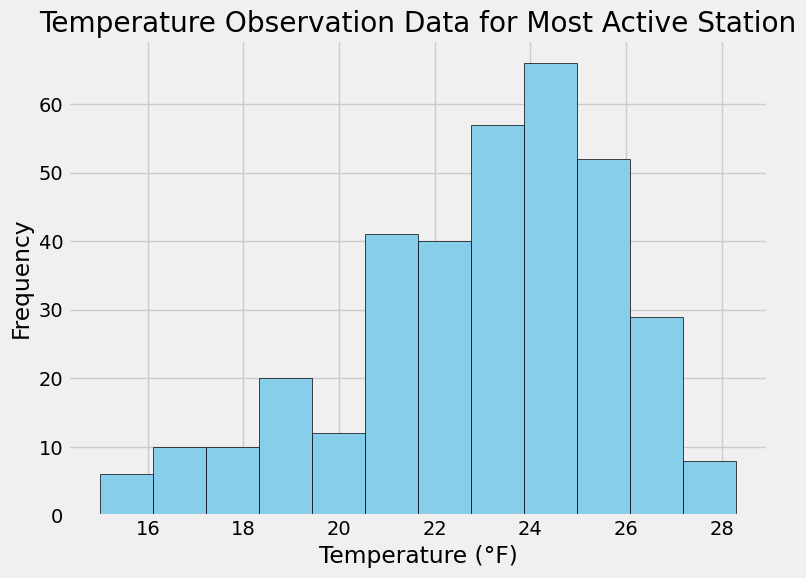

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_id = most_active_stations[0][0]

# Calculate the date 12 months ago from the most recent date in the dataset
one_year_ago = dt.datetime.strptime(most_recent_date, "%Y-%m-%d") - dt.timedelta(days=365)

# Query the temperature observation data for the last 12 months for the most active station
temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= one_year_ago).all()

# Convert the result to a DataFrame
df_temperature = pd.DataFrame(temperature_data, columns=['Temperature'])

# Plot the results as a histogram
plt.figure(figsize=(8, 6))
plt.hist(df_temperature['Temperature'], bins=12, color='skyblue', edgecolor='black')
plt.title('Temperature Observation Data for Most Active Station', color="Black")
plt.xlabel('Temperature (°F)', color="Black")
plt.ylabel('Frequency', color="Black")
plt.grid(True)
plt.xticks(color="Black")
plt.yticks(color="Black")
plt.tight_layout()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()
